In [1]:
import sys, os
sys.path.append('/d22/hin/vikasj78/GAMERA/lib') #gamera lib installation
from importlib import reload
import numpy as np
import pandas as pd
import scipy.optimize as opt
import gappa as gp
import utilities_final as util
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from uncertainties import unumpy

import scipy as sp
from scipy.interpolate import splev, splrep
from scipy import interpolate
import matplotlib.colors as colors
import astropy.units as u
import astropy.constants as c
plt.style.use('seaborn-talk')
plt.style.use('presentation.mplstyle')
%matplotlib inline

In [2]:
reload(util)

<module 'utilities_final' from '/lfs/l7/hawc/users/vikasj78/J1809-193_Analysis/hess-j1809/gamera_modelling/scripts/utilities_final.py'>

#### position of the system

In [3]:
fu = gp.Utils()
bins = 200
eV_to_TeV = 1e-12

In [4]:
location_pwn = {
    ##PSR J1809-1917 from ATNF
    'distance': 3.27e3, #pc
    'longi': 11.18, #deg 
    'lati' : 0.09,  #deg in GCS
}


In [5]:
location_snr = {
    #location of the system SNR G11.0-0.0 
    #(put at the same location as of pulsar above, most likely associated)
    'distance': 3.27e3, #pc 
    'longi': 11.18, #deg 
    'lati' : 0.09,  #deg in GCS
}

#### Known properties of the system

In [6]:
known_properties = {
    #pulsar properties
    'e_dot' : 1.8e36, #erg/sec
    'char_age' : 5.14e4, # yrs                                                                                                                                  
    'P' :  82.755269706e-3,  #sec                                                                                                                              
    'P_dot' :  2.553016e-14 #/sec/sec  
}

#### Model parameters

In [7]:
def define_model_parameters_scales(model_parameters):
    for key in model_parameters.keys():
        scale = 100./(model_parameters[key][-1] - model_parameters[key][1])
        model_parameters[key].append(scale) #apply scaling and add to dict

In [8]:
model_parameters_assumed_pwn = {
    #fixed parameters
    'br_ind' : 3.0, #pulsar braking index  (Assumed)
    'ebreak' : None, #TeV
    'alpha0' : None
}
model_parameters_fit_pwn = {
    #fit parameters, lowerbound, upperbound
    'b_now' : [4.6e-6,1e-6,8e-6], #Gauss
    'P0' : [63e-3,1e-3,82e-3], #sec
    #'P0' : [63e-3,20e-3,82e-3], #sec
    'theta' : [0.4469,0.01,1.0], #converstion frac fron pulsar lum to electrons
    'ecut' : [2.5,1.7,5.0], #log10(E/TeV)
    'alpha' : [2.2,1.8,2.7],
    #'alpha' : [2.2,1.8,3.0],
    'time_frac_xray': [0.07,0.,0.15], #For x-ray (recent electrons)
    'time_frac_pwn': [0.1,0.,0.4], #For pwn (recent electrons)
    'density' : [1,1,100]#/cm3 #low particle density region
}
define_model_parameters_scales(model_parameters_fit_pwn)
model_parameters_pwn = {**model_parameters_assumed_pwn, **model_parameters_fit_pwn}

In [9]:
model_parameters_snr = {   
    'density_mc' : [40,10,100], #/cm3 #high particle density region
    'alpha_p' : [2.4,1.9,2.9],
    'power_p' : [49,47,51], #log10(E/erg)
    'del_alpha' : [0.0,-1.0,1.0],
    'k_ep' : [-4,-7,-1], #ratio of electron spectrum norm to proton log10(Kep)
    'b_now_snr' : [100e-6,3e-6,300e-6], #Gauss
}
define_model_parameters_scales(model_parameters_snr)

In [10]:
#just for sanity check
for key in model_parameters_pwn.keys():
    print(key,model_parameters_pwn[key])
for key in model_parameters_snr.keys():
    print(key,model_parameters_snr[key])

br_ind 3.0
ebreak None
alpha0 None
b_now [4.6e-06, 1e-06, 8e-06, 14285714.285714285]
P0 [0.063, 0.001, 0.082, 1234.567901234568]
theta [0.4469, 0.01, 1.0, 101.01010101010101]
ecut [2.5, 1.7, 5.0, 30.303030303030305]
alpha [2.2, 1.8, 2.7, 111.1111111111111]
time_frac_xray [0.07, 0.0, 0.15, 666.6666666666667]
time_frac_pwn [0.1, 0.0, 0.4, 250.0]
density [1, 1, 100, 1.0101010101010102]
density_mc [40, 10, 100, 1.1111111111111112]
alpha_p [2.4, 1.9, 2.9, 100.0]
power_p [49, 47, 51, 25.0]
del_alpha [0.0, -1.0, 1.0, 50.0]
k_ep [-4, -7, -1, 16.666666666666668]
b_now_snr [0.0001, 3e-06, 0.0003, 336700.3367003368]


#### observations

In [11]:
#Radio data
df_radio = pd.read_csv("../data_points/G11.0-0.0.txt", comment="#", delim_whitespace=True)
df_radio['e_ref'] = df_radio['e_ref']*eV_to_TeV

In [12]:
#X-ray data
df_suzaku_data = pd.read_csv("../data_points/suzaku.txt", comment="#", delim_whitespace=True) #this contains the data in different grids of suzaku observation
e0_suzaku = 2e3 * gp.eV_to_erg
e1_suzaku = 10e3 *  gp.eV_to_erg
df_suzaku = util.calculate_sed_suzaku(df_suzaku_data, e0_suzaku, e1_suzaku, 5)

In [13]:
#fermi data
fermi_data = np.load('../data_points/4fgl_j1810.3-1925e_sed.npy',allow_pickle=True).item(0)
df_fermi_ul, df_fermi = util.calculate_sed_fermi(fermi_data)

In [14]:
#fermi data gammapy template
fermi_data_template = np.load('../data_points/comp1_only_sed.npy',allow_pickle=True).item(0)
df_fermi_template_ul, df_fermi_template = util.calculate_sed_fermi(fermi_data_template)

In [15]:
#hess
df_hess_relic_full = pd.read_csv("../../datafiles/3d_modeling_005_flux_points_component_01_with_new_sys_err.dat", comment="#", delim_whitespace=True)
util.calculate_sed_hess(df_hess_relic_full)
df_hess_relic = df_hess_relic_full
df_hess_pwn = pd.read_csv("../../datafiles/3d_modeling_005_flux_points_component_02_with_new_sys_err.dat", comment="#", delim_whitespace=True)
util.calculate_sed_hess(df_hess_pwn)

In [16]:
df_hess_relic[df_hess_relic.e_ref > 1]

,e_ref,e_min,e_max,dnde,dnde_err,dnde_errn,dnde_errp,dnde_ul,sqrt_ts,is_ul,sed,sed_err,sed_errp,sed_errn
4,1.154782,1.000000,1.333522,6.593108e-12,1.020342e-12,1.017181e-12,1.022686e-12,8.260054e-12,11.857747,False,1.408487e-11,2.179758e-12,2.184766e-12,2.173005e-12
5,1.539927,1.333522,1.778279,3.556361e-12,5.442552e-13,5.431541e-13,5.454650e-13,4.455294e-12,11.831374,False,1.351041e-11,2.067594e-12,2.072189e-12,2.063410e-12
6,2.053525,1.778279,2.371374,2.083187e-12,2.958845e-13,2.952861e-13,2.965475e-13,2.581232e-12,12.400414,False,1.407313e-11,1.998871e-12,2.003350e-12,1.994828e-12
7,2.738420,2.371374,3.162278,1.062353e-12,1.647481e-13,1.638408e-13,1.655446e-13,1.348452e-12,10.654293,False,1.276237e-11,1.979169e-12,1.988737e-12,1.968270e-12
8,3.651741,3.162278,4.216965,5.450103e-13,9.229872e-14,9.184832e-14,9.293119e-14,7.101495e-13,9.252229,False,1.164306e-11,1.971779e-12,1.985291e-12,1.962157e-12
9,4.869675,4.216965,5.623413,2.268752e-13,5.080693e-14,5.035634e-14,5.134932e-14,3.201118e-13,6.770060,False,8.618852e-12,1.930125e-12,1.950730e-12,1.913007e-12
10,6.493816,5.623413,7.498942,1.607995e-13,2.979128e-14,2.939218e-14,3.020589e-14,2.170786e-13,8.090190,False,1.086294e-11,2.012573e-12,2.040582e-12,1.985612e-12
11,8.659643,7.498942,10.000000,7.478785e-14,1.633853e-14,1.605761e-14,1.664102e-14,1.062652e-13,6.868079,False,8.984493e-12,1.962798e-12,1.999136e-12,1.929049e-12
12,11.547821,10.000000,13.335216,3.760234e-14,9.486559e-15,9.271869e-15,9.691653e-15,5.630458e-14,5.626037,False,8.032995e-12,2.026615e-12,2.070429e-12,1.980751e-12
13,15.399267,13.335216,17.782797,2.421169e-14,5.707023e-15,5.558609e-15,5.856437e-15,3.574926e-14,6.106207,False,9.197880e-12,2.168065e-12,2.224826e-12,2.111683e-12


In [17]:
def draw_observations_data(ax):
    ax.errorbar(df_hess_relic['e_ref'], df_hess_relic['sed'], 
                xerr = [df_hess_relic['e_ref'] - df_hess_relic['e_min'], df_hess_relic['e_max'] - df_hess_relic['e_ref']], 
                yerr = [df_hess_relic['sed_errn'], df_hess_relic['sed_errp']], 
                marker='o', linestyle='None', label ='HESS (Relic)', uplims=df_hess_relic['is_ul'], color='green')
    ax.errorbar(df_hess_pwn['e_ref'], df_hess_pwn['sed'], 
                xerr = [df_hess_pwn['e_ref'] - df_hess_pwn['e_min'], df_hess_pwn['e_max'] - df_hess_pwn['e_ref']], 
                yerr = [df_hess_pwn['sed_errn'], df_hess_pwn['sed_errp']], 
                marker='o', linestyle='None', label ='HESS (PWN)', uplims=df_hess_pwn['is_ul'], color='orange')
    ax.errorbar(df_fermi['e_ref'], df_fermi['sed'], 
                yerr = df_fermi['sed_err'], 
                marker='o', linestyle='None', label ='Fermi', color='blue')
    ax.errorbar(df_fermi_ul['e_ref'], df_fermi_ul['sed'],  
                yerr = df_fermi_ul['sed_err'],
                marker='o', linestyle='None', uplims=True, color='blue')
    ####
    ax.fill_between(df_suzaku['e_ref'],df_suzaku['sed'] + df_suzaku['sed_err'],
                    df_suzaku['sed'] - df_suzaku['sed_err'],color='magenta',label='Suzaku')
    ax.errorbar(df_radio['e_ref'], df_radio['sed'], 
                yerr = df_radio['sed_err'], 
                marker='o', linestyle='None', label ='G11.0-0.0', color='teal')
    ax.legend(ncol=2,loc='upper center', bbox_to_anchor=(0.5, 1.35))
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim(5e-19,5e3)
    ax.set_ylim(bottom=8e-15)
    ax.set_xlabel("Energy [TeV]")
    ax.set_ylabel("E"+r"$^2$"+"dN/dE [erg cm"+r"$^{-2}$"+" s"+r"$^{-1}$""]")

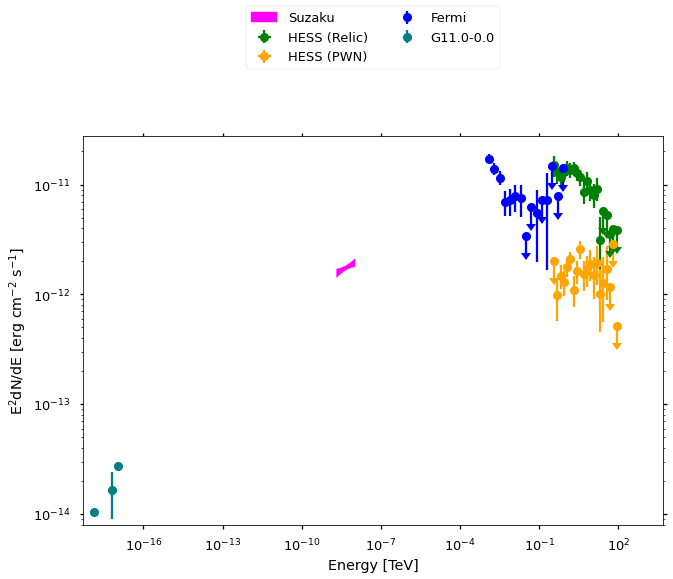

In [18]:
fig, ax = plt.subplots()
draw_observations_data(ax)

#### MCMC

#### Perform fitting (PWN)

In [19]:
fermi_thr = 0.03 #TeV
relic_eref = np.concatenate((df_fermi[df_fermi['e_ref'] > fermi_thr]['e_ref'], df_hess_relic[df_hess_relic['is_ul']==False]['e_ref']))
relic_sed = np.concatenate((df_fermi[df_fermi['e_ref'] > fermi_thr]['sed'], df_hess_relic[df_hess_relic['is_ul']==False]['sed']))
relic_sed_err = np.concatenate((df_fermi[df_fermi['e_ref'] > fermi_thr]['sed_err'], df_hess_relic[df_hess_relic['is_ul']==False]['sed_err']))

pwn_x = np.array((np.array(df_suzaku['e_ref']), 
                np.array(df_hess_pwn[df_hess_pwn['is_ul']==False]['e_ref']),
                relic_eref))*gp.TeV_to_erg #should be in ergs for gamera
pwn_y = np.array((np.array(df_suzaku['sed']),
                np.array(df_hess_pwn[df_hess_pwn['is_ul']==False]['sed']),
                relic_sed))
pwn_yerr = np.array((np.array(df_suzaku['sed_err']),
                    np.array(df_hess_pwn[df_hess_pwn['is_ul']==False]['sed_err']),
                    relic_sed_err))

/lfs/l2/hawc/users/vikasj78/software-gammapy/anaconda3/envs/gamera/lib/python3.6/site-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/lfs/l2/hawc/users/vikasj78/software-gammapy/anaconda3/envs/gamera/lib/python3.6/site-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()
/lfs/l2/hawc/users/vikasj78/software-gammapy/anaconda3/envs/gamera/lib/python3.6/site-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray 

Theta (fraction) = 5.9e-01-1.5e-01+1.8e-01
B(Now)(G) = 4.0e-06-5.4e-07+5.8e-07
P0 (s) = 4.9e-02-5.0e-03+6.3e-03
log10(Ecut/TeV) = 2.6e+00-1.8e-01+2.2e-01
spectral index (wind) = 2.0e+00-4.6e-02+4.6e-02
Time fraction (X-ray) = 3.6e-02-1.1e-02+2.2e-02
Time fraction (PWN) = 1.4e-01-3.2e-02+4.1e-02


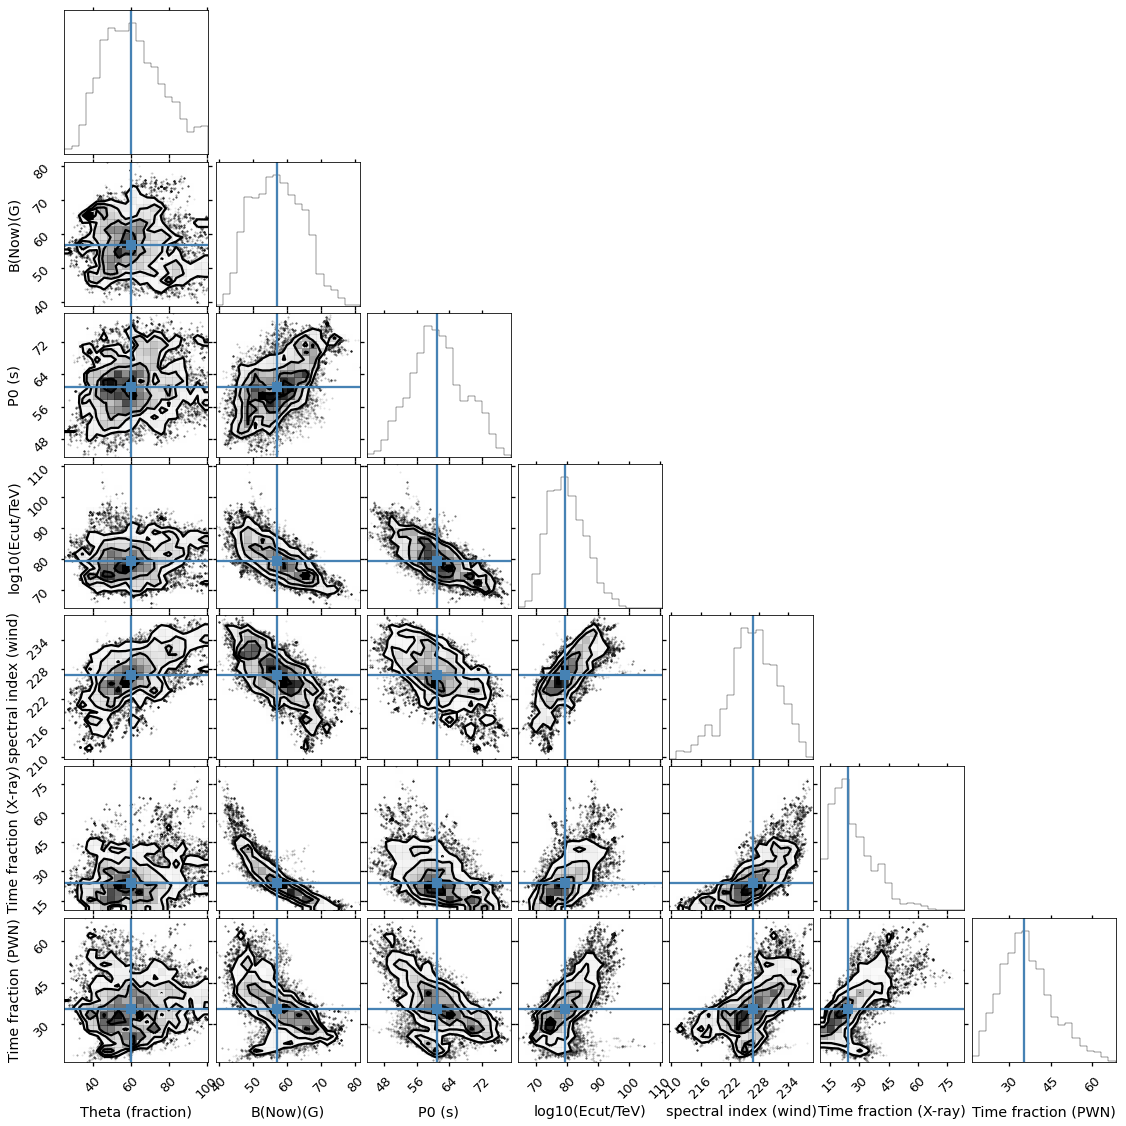

In [20]:
pwn_fit_parameters = ['theta','b_now','P0','ecut','alpha','time_frac_xray','time_frac_pwn']
pwn_labels = ["Theta (fraction)", "B(Now)(G)", "P0 (s)", "log10(Ecut/TeV)", "spectral index (wind)","Time fraction (X-ray)", "Time fraction (PWN)"]
if os.path.isfile(f'../data_points/mcmc_result_pwn.npy'):
    with open('../data_points/mcmc_result_pwn.npy', 'rb') as f:
        mcmc_result_pwn = np.load(f)
        mcmc_pwn_fit_results, mcmc_pwn_fit_results_err_high, mcmc_pwn_fit_results_err_low = util.mcmc_results("pwn", pwn_labels, pwn_fit_parameters, 
                                                                                          model_parameters_pwn, mcmc_result_pwn)
        plt.savefig(f"../plots/pwn_cornerplot.png", bbox_inches='tight')
        plt.savefig(f"../plots/pwn_cornerplot.pdf", bbox_inches='tight')
        model_parameters_pwn_after_fit = model_parameters_pwn.copy()
        #because we are using already fitted results get the pwn_fit object with the best fit parameter values
        for i,par in enumerate(pwn_fit_parameters):
            model_parameters_pwn_after_fit[par][0] = mcmc_pwn_fit_results[i]/model_parameters_pwn_after_fit[par][-1]
        pwn_fit = util.pwn_emission(bins, location_pwn, known_properties, model_parameters_pwn_after_fit)
            
else:
    pwn_fit = util.pwn_emission(bins, location_pwn, known_properties, model_parameters_pwn)
    pwn_pars = []
    pwn_lower_bounds = []
    pwn_upper_bounds = []
    for par in pwn_fit_parameters:
        pwn_pars.append(model_parameters_pwn[par][0]*model_parameters_pwn[par][-1])
        pwn_lower_bounds.append(model_parameters_pwn[par][1]*model_parameters_pwn[par][-1])
        pwn_upper_bounds.append(model_parameters_pwn[par][2]*model_parameters_pwn[par][-1])
    pwn_bounds = (pwn_lower_bounds, pwn_upper_bounds)
    mcmc_result_pwn = util.run_mcmc(7,pwn_pars,pwn_fit.log_prob_pwn,pwn_x,pwn_y,pwn_yerr)
    with open('../data_points/mcmc_result_pwn.npy', 'wb') as f:
        np.save(f, mcmc_result_pwn)
    mcmc_pwn_fit_results, mcmc_pwn_fit_results_err_high, mcmc_pwn_fit_results_err_low = util.mcmc_results("pwn", pwn_labels, pwn_fit_parameters, 
                                                                                          model_parameters_pwn, mcmc_result_pwn)
    plt.savefig(f"../plots/pwn_cornerplot.png", bbox_inches='tight')
    plt.savefig(f"../plots/pwn_cornerplot.pdf", bbox_inches='tight')

In [21]:
true_age = pwn_fit.calculate_true_age()/1e3
xray_age = pwn_fit.calculate_true_age()*mcmc_pwn_fit_results[-2]/model_parameters_fit_pwn['time_frac_xray'][-1]/1e3
xray_age_errp = pwn_fit.calculate_true_age()*mcmc_pwn_fit_results_err_high[-2]/model_parameters_fit_pwn['time_frac_xray'][-1]/1e3
xray_age_errn = pwn_fit.calculate_true_age()*mcmc_pwn_fit_results_err_low[-2]/model_parameters_fit_pwn['time_frac_xray'][-1]/1e3
print("True age (kyrs): {:.1f}".format(true_age))
print("Recent electrons (X-ray) (kyrs): {:.1f} + {:.1f} - {:.1f}".format(xray_age,xray_age_errp,xray_age_errn))
pwn_age = pwn_fit.calculate_true_age()*mcmc_pwn_fit_results[-1]/model_parameters_fit_pwn['time_frac_pwn'][-1]/1e3
pwn_age_errp = pwn_fit.calculate_true_age()*mcmc_pwn_fit_results_err_high[-1]/model_parameters_fit_pwn['time_frac_pwn'][-1]/1e3
pwn_age_errn = pwn_fit.calculate_true_age()*mcmc_pwn_fit_results_err_low[-1]/model_parameters_fit_pwn['time_frac_pwn'][-1]/1e3
print("Recent electrons (PWN) (kyrs): {:.1f} + {:.1f} - {:.1f}".format(pwn_age,pwn_age_errp,pwn_age_errn))
relic_age = true_age - pwn_age
print("Relic age (kyrs): {:.1f}".format(relic_age))

True age (kyrs): 33.1
Recent electrons (X-ray) (kyrs): 1.2 + 0.7 - 0.4
Recent electrons (PWN) (kyrs): 4.7 + 1.4 - 1.1
Relic age (kyrs): 28.4


In [60]:
mcmc_pwn_fit_results

array([ 59.91395517,  56.96977978,  60.92727132,  79.42281368,
       226.78581678,  23.9708686 ,  35.50956873])

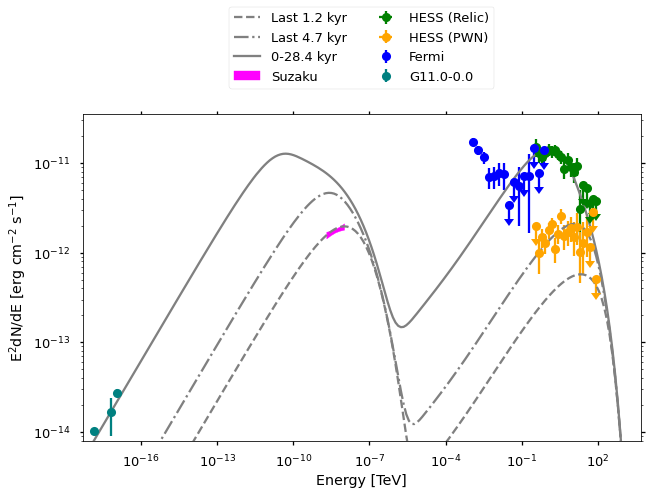

In [22]:
f, ax = plt.subplots(1,figsize=(10,6))     
pwn_sed_xray, pwn_sed_pwn, pwn_sed_relic, fp_pwn, fr_pwn = util.get_pwn_sed(pwn_fit, mcmc_pwn_fit_results)
ax.plot(pwn_sed_xray[:,0],pwn_sed_xray[:,1],linestyle="--",color='grey',label="Last {:.1f} kyr".format(xray_age))
ax.plot(pwn_sed_pwn[:,0],pwn_sed_pwn[:,1],linestyle="-.",color='grey',label="Last {:.1f} kyr".format(pwn_age))
ax.plot(pwn_sed_relic[:,0],pwn_sed_relic[:,1],linestyle="-",color='grey', label="0-{:.1f} kyr".format(relic_age))
draw_observations_data(ax)
f.savefig("../plots/pwn_sed_mcmc.png",bbox_inches='tight')
f.savefig("../plots/pwn_sed_mcmc.pdf",bbox_inches='tight')

#### Perform fitting (SNR electrons and protons)

In [23]:
fermi_thr = 0.03 #TeV
snr_x = np.concatenate((df_radio['e_ref'],
                   df_fermi[df_fermi['e_ref'] < fermi_thr]['e_ref']))*gp.TeV_to_erg #these should be in ergs for gamera
snr_y = np.concatenate((df_radio['sed'],
                   df_fermi[df_fermi['e_ref'] < fermi_thr]['sed']))

snr_yerr = np.concatenate((df_radio['sed_err'],
                          df_fermi[df_fermi['e_ref'] < fermi_thr]['sed_err']))

alpha_p = 2.5e+00-7.5e-02+9.1e-02
log10(power_p/erg) = 4.9e+01-4.9e-02+5.2e-02
del_alpha = -3.4e-01-1.6e-01+1.5e-01
log10(k_ep) = -3.7e+00-2.7e-01+4.2e-01
b_now_snr (G) = 1.8e-04-8.1e-05+8.1e-05


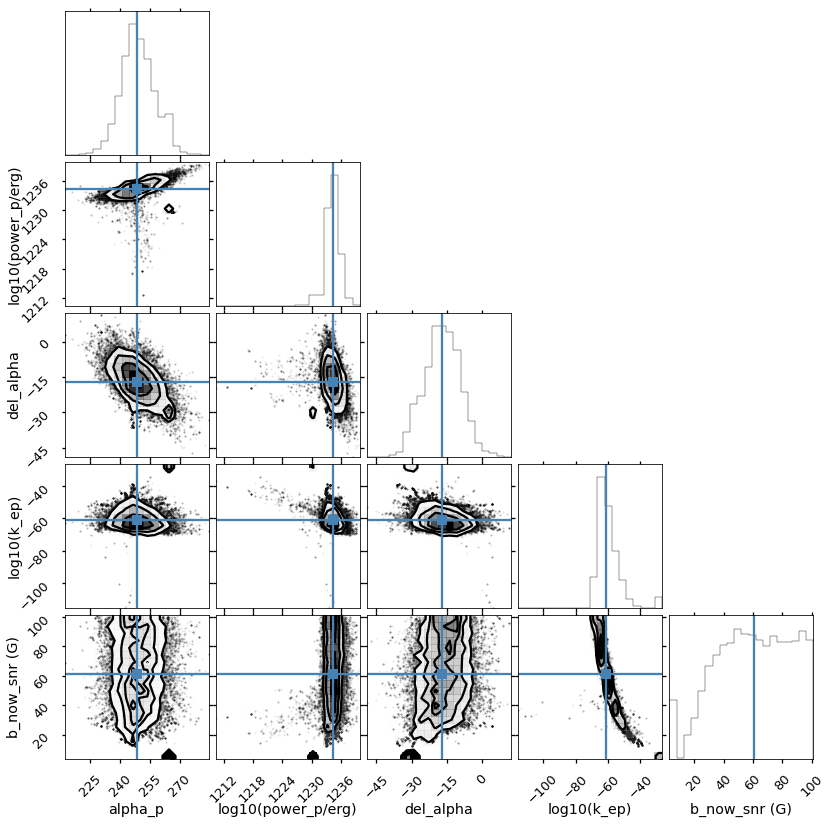

In [24]:
snr_labels = ["alpha_p", "log10(power_p/erg)", "del_alpha", "log10(k_ep)", "b_now_snr (G)"]
snr_fit_parameters = ['alpha_p','power_p','del_alpha','k_ep','b_now_snr']
if os.path.isfile(f'../data_points/mcmc_result_snr.npy'):
    with open('../data_points/mcmc_result_snr.npy', 'rb') as f:
        mcmc_result_snr = np.load(f)
    mcmc_snr_fit_results, mcmc_snr_fit_results_err_high, mcmc_snr_fit_results_err_low = util.mcmc_results("snr", snr_labels, snr_fit_parameters, 
                                                                                                      model_parameters_snr, mcmc_result_snr)
    plt.savefig(f"../plots/snr_cornerplot.png", bbox_inches='tight')
    plt.savefig(f"../plots/snr_cornerplot.pdf", bbox_inches='tight')
    model_parameters_snr_after_fit = model_parameters_snr.copy()
    #because we are using already fitted results get the snr_fit object with the best fit parameter values
    for i,par in enumerate(snr_fit_parameters):
        model_parameters_snr_after_fit[par][0] = mcmc_snr_fit_results[i]/model_parameters_snr_after_fit[par][-1]
    snr_fit = util.snr_emission(bins, location_snr, model_parameters_snr_after_fit)
    
else:
    snr_fit = util.snr_emission(bins, location_snr, model_parameters_snr)
    snr_pars = []
    snr_lower_bounds = []
    snr_upper_bounds = []
    for par in snr_fit_parameters:
        snr_pars.append(model_parameters_snr[par][0]*model_parameters_snr[par][-1])
        snr_lower_bounds.append(model_parameters_snr[par][1]*model_parameters_snr[par][-1])
        snr_upper_bounds.append(model_parameters_snr[par][2]*model_parameters_snr[par][-1])
    snr_bounds = (snr_lower_bounds, snr_upper_bounds)

    mcmc_result_snr = util.run_mcmc(5,snr_pars,snr_fit.log_prob_snr,snr_x,snr_y,snr_yerr)
    with open('../data_points/mcmc_result_snr.npy', 'wb') as f:
        np.save(f, mcmc_result_snr)
    mcmc_snr_fit_results, mcmc_snr_fit_results_err_high, mcmc_snr_fit_results_err_low = util.mcmc_results("snr", snr_labels, snr_fit_parameters, 
                                                                                                      model_parameters_snr, mcmc_result_snr)
    plt.savefig(f"../plots/snr_cornerplot.png", bbox_inches='tight')
    plt.savefig(f"../plots/snr_cornerplot.pdf", bbox_inches='tight')

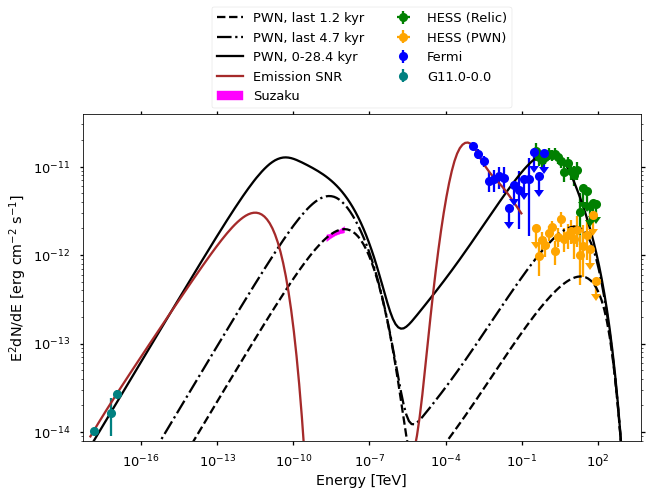

In [25]:
f, ax = plt.subplots(1,figsize=(10,6))  
#PWN
pwn_sed_xray, pwn_sed_pwn, pwn_sed_relic, fp_pwn, fr_pwn = util.get_pwn_sed(pwn_fit, mcmc_pwn_fit_results)
ax.plot(pwn_sed_xray[:,0],pwn_sed_xray[:,1],linestyle="--",color='black',label="PWN, last {:.1f} kyr".format(xray_age))
ax.plot(pwn_sed_pwn[:,0],pwn_sed_pwn[:,1],linestyle="-.",color='black',label="PWN, last {:.1f} kyr".format(pwn_age))
ax.plot(pwn_sed_relic[:,0],pwn_sed_relic[:,1],linestyle="-",color='black', label="PWN, 0-{:.1f} kyr".format(relic_age))
#SNR
snr_sed, fr_snr = util.get_snr_sed(snr_fit, mcmc_snr_fit_results)
snr_sed_energy = snr_sed[:,0]
snr_sed_values = snr_sed[:,1]
snr_sed_energy_plot = snr_sed_energy[snr_sed_energy < 0.1]
snr_sed_values_plot = snr_sed_values[snr_sed_energy < 0.1]
ax.plot(snr_sed_energy_plot,snr_sed_values_plot,linestyle="-",color='brown', label='Emission SNR')
draw_observations_data(ax)

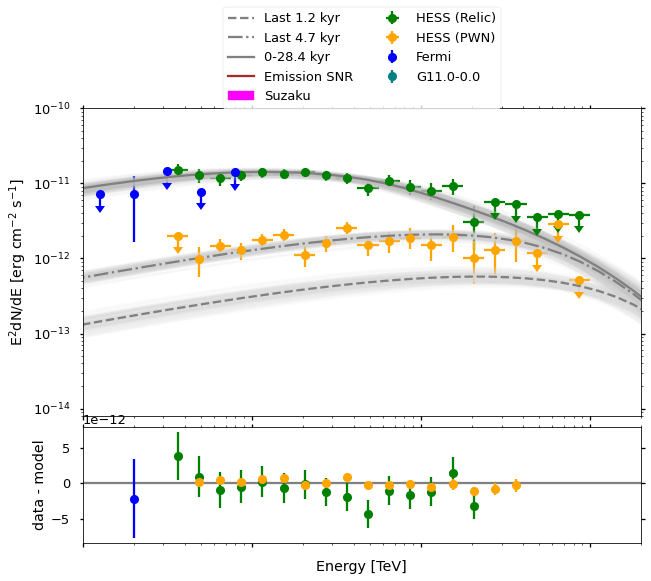

In [26]:
if (os.path.isfile(f'../data_points/pwn_seds.npy') and os.path.isfile(f'../data_points/snr_seds.npy') and os.path.isfile(f'../data_points/residual_seds.npy')):
    with open('../data_points/pwn_seds.npy', 'rb') as f:
        pwn_seds = np.load(f)
    with open('../data_points/snr_seds.npy', 'rb') as f:
        snr_seds = np.load(f)
    with open('../data_points/residual_seds.npy', 'rb') as f:
        residual_seds = np.load(f, allow_pickle=True)
    
    f, ax = plt.subplots(1,figsize=(10,8))   
    gs = GridSpec(7, 1)
    ax = plt.subplot(gs[:5, :])
    for ps in pwn_seds[:-1,:,:,:]:
        ax.plot(ps[0][:,0], ps[0][:,1], color="gainsboro",linestyle="-", alpha=0.1)
        ax.plot(ps[1][:,0], ps[1][:,1], color="lightgrey",linestyle="-", alpha=0.1)
        ax.plot(ps[2][:,0], ps[2][:,1], color="silver",linestyle="-", alpha=0.1)
    ax.plot(pwn_seds[-1][0][:,0],pwn_seds[-1][0][:,1],linestyle="--",color='grey',label="Last {:.1f} kyr".format(xray_age))
    ax.plot(pwn_seds[-1][1][:,0],pwn_seds[-1][1][:,1],linestyle="-.",color='grey',label="Last {:.1f} kyr".format(pwn_age))
    ax.plot(pwn_seds[-1][2][:,0],pwn_seds[-1][2][:,1],linestyle="-",color='grey', label="0-{:.1f} kyr".format(relic_age))
    for ps in snr_seds[:-1,:,:]:
        sed_energy = ps[:,0]
        sed_values = ps[:,1]
        sed_energy_plot = sed_energy[sed_energy < 0.1]
        sed_values_plot = sed_values[sed_energy < 0.1]
        ax.plot(sed_energy_plot, sed_values_plot, color="salmon",linestyle="-", alpha=0.1)
    snr_sed_energy = snr_seds[-1][:,0]
    snr_sed_values = snr_seds[-1][:,1]
    snr_sed_energy_plot = snr_sed_energy[snr_sed_energy < 0.1]
    snr_sed_values_plot = snr_sed_values[snr_sed_energy < 0.1]
    ax.plot(snr_sed_energy_plot,snr_sed_values_plot,linestyle="-",color='brown', label='Emission SNR')
    draw_observations_data(ax)

    #residuals
    ax_residuals = plt.subplot(gs[5:, :], sharex=ax)
    ax_residuals = plt.gca()
    x_min, x_max = ax_residuals.get_xlim()
    ax_residuals.hlines(0, x_min, x_max, ls="-", color="grey")

    #radio
    ax_residuals.errorbar(residual_seds[0][0], residual_seds[0][1], yerr=residual_seds[0][2], color='teal',marker='o',capsize = 5, linestyle='None')
    #fermi
    ax_residuals.errorbar(residual_seds[1][0], residual_seds[1][1], yerr=residual_seds[1][2], 
                          color='blue',marker='o',capsize = 5, linestyle='None')
    #suzaku
    ax_residuals.errorbar(residual_seds[2][0], residual_seds[2][1], yerr=residual_seds[2][2], color='magenta',marker='o',capsize = 5, linestyle='None')
    #relic
    ax_residuals.errorbar(residual_seds[3][0], residual_seds[3][1], yerr=residual_seds[3][2], color='blue',marker='o',capsize = 5, linestyle='None')
    ax_residuals.errorbar(residual_seds[4][0], residual_seds[4][1], yerr=residual_seds[4][2],color='green',marker='o',capsize = 5, linestyle='None')
    #pwn
    ax_residuals.errorbar(residual_seds[5][0], residual_seds[5][1], yerr=residual_seds[5][2],
                          color='orange',marker='o',capsize = 5, linestyle='None')
    ax.set_ylim(top=1e-10)
    #ax_residuals.set_ylabel(r"$\frac{\rm {data - model}}{\rm{data \; error}}$")
    ax_residuals.set_ylabel("data - model")
    ax_residuals.set_xlabel("Energy [TeV]")
    ax.set_xticklabels([])
    f.savefig("../plots/full_sed_mcmc.png",bbox_inches='tight')
    f.savefig("../plots/full_sed_mcmc.pdf",bbox_inches='tight')
    ax.set_xlim(0.1,200)
    f.savefig("../plots/full_sed_mcmc_ZoomIn.png",bbox_inches='tight')
    f.savefig("../plots/full_sed_mcmc_ZoomIn.pdf",bbox_inches='tight')
else:                                                                
    f, ax = plt.subplots(1,figsize=(10,8))   
    gs = GridSpec(7, 1)
    ax = plt.subplot(gs[:5, :])
    pwn_seds = list()
    snr_seds = list()
    residual_seds = list()
    if(True): #this takes about 20 mins
        inds = np.random.randint(len(mcmc_result_pwn), size=7*33*1500) #num_pars * walkers * samples
        high_lim = mcmc_pwn_fit_results + mcmc_pwn_fit_results_err_high
        low_lim = mcmc_pwn_fit_results - mcmc_pwn_fit_results_err_low
        count = 0
        for ind in inds:
            sample = mcmc_result_pwn[ind]
            if(util.check_sample_within_errs(sample, low_lim, high_lim) and count <= 100):
                sed_xray, sed_pwn, sed_relic, _, _ = util.get_pwn_sed(pwn_fit, sample)
                pwn_seds.append([sed_xray,sed_pwn,sed_relic])
                ax.plot(sed_xray[:,0], sed_xray[:,1], color="gainsboro",linestyle="-", alpha=0.1)
                ax.plot(sed_pwn[:,0], sed_pwn[:,1], color="lightgrey",linestyle="-", alpha=0.1)
                ax.plot(sed_relic[:,0], sed_relic[:,1], color="silver",linestyle="-", alpha=0.1)
                count = count + 1
            else:
                continue

    if(True): #for snr
        inds = np.random.randint(len(mcmc_result_snr), size=5*33*1500) #num_pars * walkers * samples
        high_lim = mcmc_snr_fit_results + mcmc_snr_fit_results_err_high
        low_lim = mcmc_snr_fit_results - mcmc_snr_fit_results_err_low
        count = 0
        for ind in inds:
            sample = mcmc_result_snr[ind]
            if(util.check_sample_within_errs(sample, low_lim, high_lim) and count <= 100):
                sed,_ = util.get_snr_sed(snr_fit, sample)
                sed_energy = sed[:,0]
                sed_values = sed[:,1]
                sed_energy_plot = sed_energy[sed_energy < 0.1]
                sed_values_plot = sed_values[sed_energy < 0.1]
                snr_seds.append(sed)
                ax.plot(sed_energy_plot, sed_values_plot, color="salmon",linestyle="-", alpha=0.1)
                count = count + 1
            else:
                continue

    pwn_sed_xray, pwn_sed_pwn, pwn_sed_relic, fp_pwn, fr_pwn = util.get_pwn_sed(pwn_fit, mcmc_pwn_fit_results)
    pwn_seds.append([pwn_sed_xray,pwn_sed_pwn,pwn_sed_relic])
    ax.plot(pwn_sed_xray[:,0],pwn_sed_xray[:,1],linestyle="--",color='grey',label="Last {:.1f} kyr".format(xray_age))
    ax.plot(pwn_sed_pwn[:,0],pwn_sed_pwn[:,1],linestyle="-.",color='grey',label="Last {:.1f} kyr".format(pwn_age))
    ax.plot(pwn_sed_relic[:,0],pwn_sed_relic[:,1],linestyle="-",color='grey', label="0-{:.1f} kyr".format(relic_age))
    snr_sed, fr_snr = util.get_snr_sed(snr_fit, mcmc_snr_fit_results)
    snr_seds.append(snr_sed)
    snr_sed_energy = snr_sed[:,0]
    snr_sed_values = snr_sed[:,1]
    snr_sed_energy_plot = snr_sed_energy[snr_sed_energy < 0.1]
    snr_sed_values_plot = snr_sed_values[snr_sed_energy < 0.1]
    ax.plot(snr_sed_energy_plot,snr_sed_values_plot,linestyle="-",color='brown', label='Emission SNR')
    draw_observations_data(ax)

    #residuals
    ax_residuals = plt.subplot(gs[5:, :], sharex=ax)
    ax_residuals = plt.gca()
    x_min, x_max = ax_residuals.get_xlim()
    ax_residuals.hlines(0, x_min, x_max, ls="-", color="grey")

    #radio
    res_radio = util.get_residuals(snr_fit, mcmc_snr_fit_results, df_radio['e_ref'], df_radio['sed'], df_radio['sed_err'], 'snr')
    ax_residuals.errorbar(df_radio['e_ref'], res_radio, yerr=df_radio['sed_err'], color='teal',marker='o',capsize = 5, linestyle='None')
    residual_seds.append([df_radio['e_ref'],res_radio, df_radio['sed_err']])
    #fermi
    res_fermi_snr = util.get_residuals(snr_fit, mcmc_snr_fit_results, df_fermi[df_fermi['e_ref'] < fermi_thr]['e_ref'], df_fermi[df_fermi['e_ref'] < fermi_thr]['sed'],
                                   df_fermi[df_fermi['e_ref'] < fermi_thr]['sed_err'], 'snr')
    ax_residuals.errorbar(df_fermi[df_fermi['e_ref'] < fermi_thr]['e_ref'], res_fermi_snr, yerr=df_fermi[df_fermi['e_ref'] < fermi_thr]['sed_err'], 
                          color='blue',marker='o',capsize = 5, linestyle='None')
    residual_seds.append([df_fermi[df_fermi['e_ref'] < fermi_thr]['e_ref'],res_fermi_snr, df_fermi[df_fermi['e_ref'] < fermi_thr]['sed_err']])
    #suzaku
    res_xray = util.get_residuals(pwn_fit, mcmc_pwn_fit_results, df_suzaku['e_ref'], df_suzaku['sed'], df_suzaku['sed_err'], 'pwn', 'suzaku')
    ax_residuals.errorbar(df_suzaku['e_ref'], res_xray, yerr=df_suzaku['sed_err'], color='magenta',marker='o',capsize = 5, linestyle='None')

    residual_seds.append([df_suzaku['e_ref'],res_xray, df_suzaku['sed_err']])
    #relic
    res_relic = util.get_residuals(pwn_fit, mcmc_pwn_fit_results, relic_eref, relic_sed, relic_sed_err, 'pwn', 'relic')
    hess_start_energy = df_hess_relic[df_hess_relic['is_ul']==False]['e_ref'].values[0]
    ax_residuals.errorbar(relic_eref[relic_eref < hess_start_energy],res_relic[relic_eref < hess_start_energy], 
                          yerr=relic_sed_err[relic_eref < hess_start_energy], color='blue',marker='o',capsize = 5, linestyle='None')
    ax_residuals.errorbar(relic_eref[relic_eref >= hess_start_energy],res_relic[relic_eref >= hess_start_energy], 
                          yerr=relic_sed_err[relic_eref >= hess_start_energy],color='green',marker='o',capsize = 5, linestyle='None')
    residual_seds.append([relic_eref[relic_eref < hess_start_energy],res_relic[relic_eref < hess_start_energy], relic_sed_err[relic_eref < hess_start_energy]])
    residual_seds.append([relic_eref[relic_eref >= hess_start_energy],res_relic[relic_eref >= hess_start_energy], relic_sed_err[relic_eref >= hess_start_energy]])
    #pwn
    res_hess_pwn = util.get_residuals(pwn_fit, mcmc_pwn_fit_results, np.array(df_hess_pwn[df_hess_pwn['is_ul']==False]['e_ref']), 
                             np.array(df_hess_pwn[df_hess_pwn['is_ul']==False]['sed']), np.array(df_hess_pwn[df_hess_pwn['is_ul']==False]['sed_err']), 'pwn', 'pwn')
    ax_residuals.errorbar(np.array(df_hess_pwn[df_hess_pwn['is_ul']==False]['e_ref']),res_hess_pwn, yerr=np.array(df_hess_pwn[df_hess_pwn['is_ul']==False]['sed_err']),
                          color='orange',marker='o',capsize = 5, linestyle='None')
    residual_seds.append([np.array(df_hess_pwn[df_hess_pwn['is_ul']==False]['e_ref']),res_hess_pwn, np.array(df_hess_pwn[df_hess_pwn['is_ul']==False]['sed_err'])])
    ax.set_ylim(top=1e-10)
    #ax_residuals.set_ylabel(r"$\frac{\rm {data - model}}{\rm{data \; error}}$")
    ax_residuals.set_ylabel("data - model")
    ax_residuals.set_xlabel("Energy [TeV]")
    ax.set_xticklabels([])
    f.savefig("../plots/full_sed_mcmc.png",bbox_inches='tight')
    f.savefig("../plots/full_sed_mcmc.pdf",bbox_inches='tight')
    ax.set_xlim(0.1,200)
    f.savefig("../plots/full_sed_mcmc_ZoomIn.png",bbox_inches='tight')
    f.savefig("../plots/full_sed_mcmc_ZoomIn.pdf",bbox_inches='tight')
    with open('../data_points/pwn_seds.npy', 'wb') as f:
        np.save(f, np.array(pwn_seds))
    with open('../data_points/snr_seds.npy', 'wb') as f:
        np.save(f, np.array(snr_seds))     
    with open('../data_points/residual_seds.npy', 'wb') as f:
        np.save(f, np.array(residual_seds))                                                                

#### Diagonostic plots

In [27]:
t = np.logspace(0, 5 ,20000) # array of times from 1 to 100k yrs                                                                                                                                                                       
e_photon = np.logspace(-6,15,bins) * gp.eV_to_erg # defines energies at which gamma-ray emission should be calculated 
e_electron = np.logspace(np.log10(gp.m_e/gp.TeV_to_erg),4,bins) * gp.TeV_to_erg #defines the injected electron energy range
e_electron_snr = np.logspace(np.log10(gp.m_e/gp.TeV_to_erg),1,bins) * gp.TeV_to_erg
e_proton_snr = np.logspace(-5,4,bins) * gp.TeV_to_erg

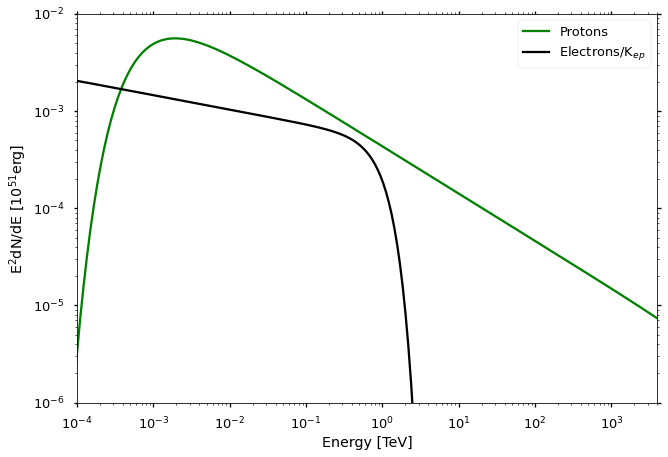

In [28]:
f, ax = plt.subplots()
power_protons = np.power(10,snr_fit.power_p)
proton_inj_spec = np.array(snr_fit.injection_spectrum(e_proton_snr,snr_fit.alpha_p,gp.m_p/gp.TeV_to_erg,
                                                         np.power(10,5),power_protons,1)) #high cut off set to very high value therefore not used
alpha_e = snr_fit.alpha_p + snr_fit.del_alpha
power_electrons =  power_protons #*np.power(10,hybrid_fit.k_ep)
electron_inj_spec = np.array(snr_fit.injection_spectrum(e_electron_snr,alpha_e,gp.m_e/gp.TeV_to_erg,
                                                           1,power_electrons,2))

ax.plot(proton_inj_spec[:,0]/gp.TeV_to_erg,np.power(proton_inj_spec[:,0],2)*proton_inj_spec[:,1]/1e51, color='green', label="Protons")
ax.plot(electron_inj_spec[:,0]/gp.TeV_to_erg,np.power(electron_inj_spec[:,0],2)*electron_inj_spec[:,1]/1e51, color='black', label="Electrons/K$_{ep}$")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1e-4,4e3)
ax.set_ylim(1e-6,1e-2)
ax.legend()
plt.xlabel("Energy [TeV]")
plt.ylabel("E"+r"$^2$"+"dN/dE [10$^{51}$erg]")
f.savefig("../plots/snr_inj_spec.png",bbox_inches='tight')
f.savefig("../plots/snr_inj_spec.pdf",bbox_inches='tight')

In [29]:
def plot_rad_fields(fr, ax, label):
    fields={
    'cmb':[0,2.5e-3], #eV
    'IR':[2.5e-3,2e-1], #eV
    'optical':[2e-1,10], #eV
    }
    #Extracting the used radiation fields 
    rad_fields = np.array(fr.GetTargetPhotons())
    rad_fields_flux = rad_fields[:,1] / gp.eV_to_erg
    rad_fields[:,1] *= rad_fields[:,0]**2 / gp.eV_to_erg
    rad_fields[:,0] /= gp.eV_to_erg
    int_rad_field_density = fu.Integrate(list(zip(rad_fields[:,0],rad_fields[:,1])))
    ax.loglog(rad_fields[:,0],rad_fields[:,1],label=label)
    for fd in fields.keys():
        rad_fields_energy = np.array(rad_fields[:,0])
        rad_fields_density = np.array(rad_fields[:,1])
        energy_range = rad_fields_energy[(rad_fields_energy > fields[fd][0]) & (rad_fields_energy <= fields[fd][1])]
        field_density = rad_fields_density[(rad_fields_energy > fields[fd][0]) & (rad_fields_energy <= fields[fd][1])]
        int_density = fu.Integrate(list(zip(energy_range,field_density)))
        temp = np.power(int_density/0.0047225517614,0.25) #Kelvin      
        print(fd, "{:.1e} eV/cm3".format(int_density), "{:.1e} K".format(temp))
    print("int_rad_field_density",label, int_rad_field_density, "eV/cm3")
    return int_rad_field_density

cmb 2.2e-04 eV/cm3 4.6e-01 K
IR 3.1e-02 eV/cm3 1.6e+00 K
optical 2.3e+00 eV/cm3 4.7e+00 K
int_rad_field_density PWN 2.449983760156512 eV/cm3


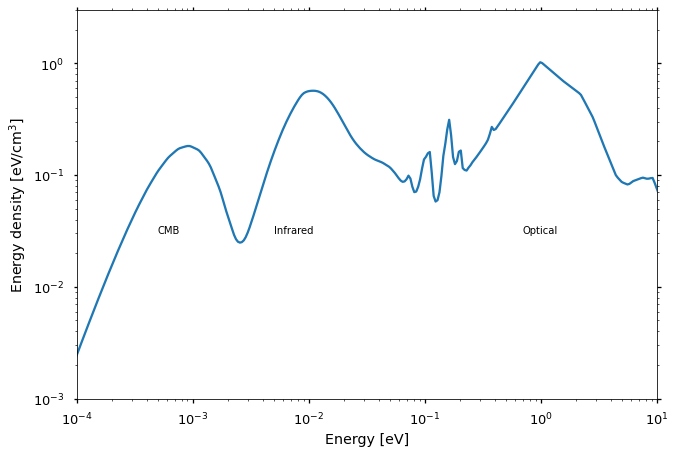

In [30]:
f, ax = plt.subplots() 
int_rad_field_density_pwn = plot_rad_fields(fr_pwn, ax, "PWN")
#int_rad_field_density_snr = plot_rad_fields(fr_snr, ax, "SNR")
plt.xlabel("Energy [eV]")
plt.ylabel("Energy density [eV/cm$^3$]")
plt.text(5e-4,3e-2,'CMB')
plt.text(5e-3,3e-2,'Infrared')
plt.text(7e-1,3e-2,'Optical')
plt.axis([1e-4,1e1,1e-3,3e0])
f.savefig("../plots/Radiation_fields.png",bbox_inches='tight')
f.savefig("../plots/Radiation_fields.pdf",bbox_inches='tight')

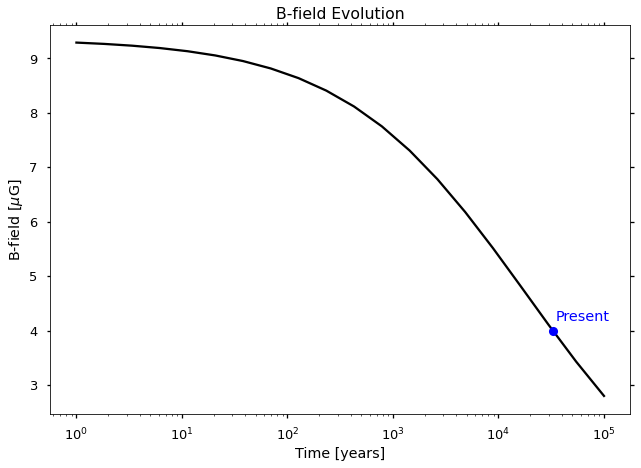

In [31]:
t = np.logspace(0, 5 ,20) # array of times from 1 to 100k yrs 
f, ax = plt.subplots()
ax.semilogx(t,pwn_fit.bfield(t)/1e-6,c='black')
ax.plot(pwn_fit.calculate_true_age(),pwn_fit.b_now/1e-6,'-bo')
ax.text(1.05*pwn_fit.calculate_true_age(),1.05*pwn_fit.b_now/1e-6,'Present',fontsize='x-large',color='b')
plt.xlabel("Time [years]")
plt.ylabel("B-field [$\mu$G]")
plt.title("B-field Evolution")
f.savefig("../plots/time_evolution_bfeild.png",bbox_inches="tight")
f.savefig("../plots/time_evolution_bfeild.pdf",bbox_inches="tight")

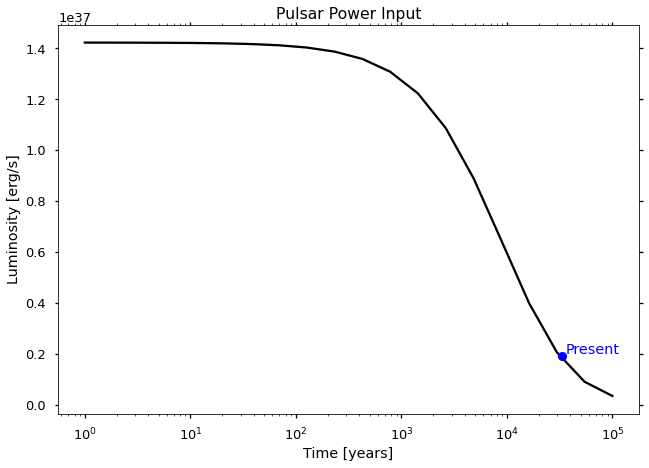

In [32]:
f, ax = plt.subplots()
ax.semilogx(t,pwn_fit.luminosity(t)/pwn_fit.theta,c='black')
ax.plot(pwn_fit.calculate_true_age(),1.05*pwn_fit.e_dot,'-bo')
ax.text(1.1*pwn_fit.calculate_true_age(),1.1*pwn_fit.e_dot,'Present',fontsize='x-large',color='b')
plt.xlabel("Time [years]")
plt.ylabel("Luminosity [erg/s]")
plt.title("Pulsar Power Input")
f.savefig("../plots/time_evolution_luminosity.png",bbox_inches="tight")
f.savefig("../plots/time_evolution_luminosity.pdf",bbox_inches="tight")

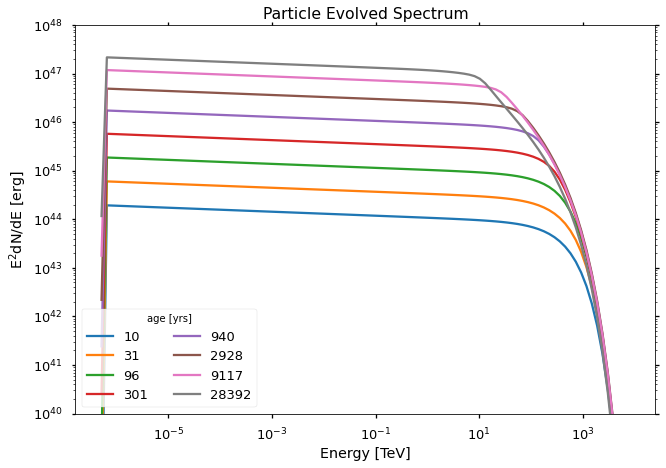

In [33]:
#evolved particle spectrum plot
ppe = []
t = np.logspace(1,np.log10(relic_age*1000),8)
for tt in t:
        fp_pwn.SetAge(tt)
        fp_pwn.CalculateElectronSpectrum()
        ppe.append(np.array(fp_pwn.GetParticleSED()))

f, ax = plt.subplots()
for pe,tt in zip(ppe,t):
    ax.loglog(pe[:,0],pe[:,1],label=str(int(tt)))
plt.xlabel("Energy [TeV]")
plt.ylabel("E"+r"$^2$"+"dN/dE [erg]")
plt.legend(title="age [yrs]",ncol=2,loc="lower left")
plt.ylim(ymin=1e40,ymax=1e48)
#plt.xlim(xmin=1.5e-1,xmax=5e3)
plt.title("Particle Evolved Spectrum")
f.savefig("../plots/ev_spectra.png",bbox_inches='tight')
f.savefig("../plots/ev_spectra.pdf",bbox_inches='tight')

#### Size calculation

In [34]:
t = np.logspace(0, 5 ,20000) # array of times from 1 to 100k yrs
e_electron = np.logspace(np.log10(gp.m_e/gp.TeV_to_erg),4,400) * gp.TeV_to_erg 
e_photon = np.logspace(-2,2.5,bins) * gp.TeV_to_erg 

#### Let's get the PWN

In [35]:
gamma_sed, fp, fr = pwn_fit.model_pwn(t, e_electron, e_photon, 1-pwn_fit.time_frac_pwn, False)

In [36]:
nBinsElectronSpectrum = 400
if os.path.isfile(f'../data_points/electron_spectrum_full_{nBinsElectronSpectrum}bins.npy'):
    with open(f'../data_points/electron_spectrum_full_{nBinsElectronSpectrum}bins.npy', 'rb') as f:
        electron_spectrum_full = np.load(f)
else:
    fp.CalculateElectronSpectrum(bins=nBinsElectronSpectrum)
    electron_spectrum_full = np.array(fp.GetParticleSpectrum())
    with open(f'../data_points/electron_spectrum_full_{nBinsElectronSpectrum}bins.npy', 'wb') as f:
        np.save(f, electron_spectrum_full)

#### Make Electron energy to Gamma energy template
#### this is because we have cooling time and therefore size only as a function of electron energy
#### and we want to get it in the end as a function of Gamma energy and match with the observations

In [37]:
#Get the spline interpolated gamma sed
spl_g_sed = splrep(gamma_sed[:,0], gamma_sed[:,1])

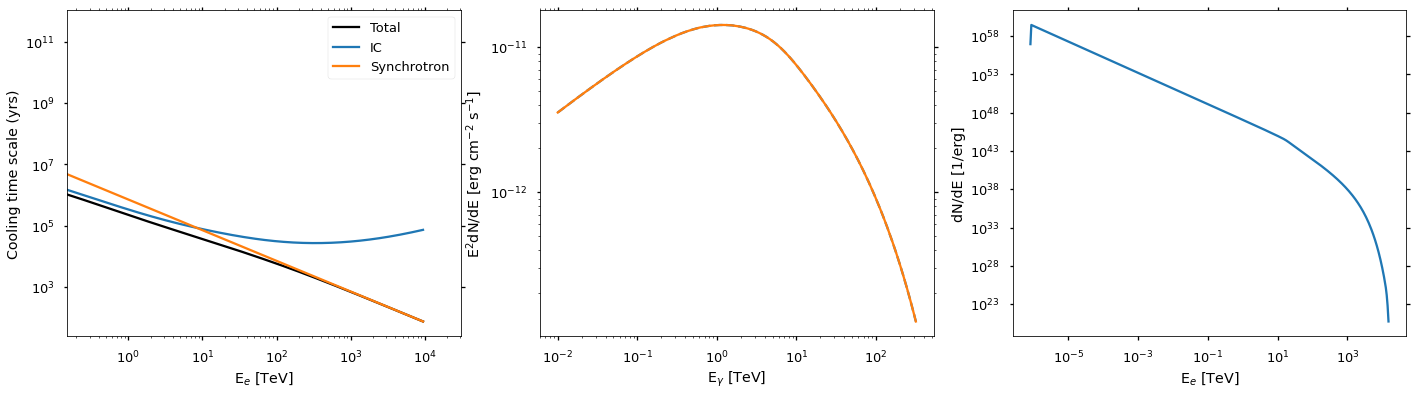

In [38]:
f, ax = plt.subplots(1,3, figsize=(24,6))
#cooling timesclaes
total = np.array(fp.GetCoolingTimeScale(electron_spectrum_full[:,0],"sum"))
ic = np.array(fp.GetCoolingTimeScale(electron_spectrum_full[:,0],"inverse_compton"))
sync = np.array(fp.GetCoolingTimeScale(electron_spectrum_full[:,0],"synchrotron"))

ax[0].loglog(total[:,0]/gp.TeV_to_erg,total[:,1],c="black",ls="-",label="Total", )
ax[0].loglog(ic[:,0]/gp.TeV_to_erg,ic[:,1],c="tab:blue",ls="-",label="IC")
ax[0].loglog(sync[:,0]/gp.TeV_to_erg,sync[:,1],c="tab:orange",ls="-",label="Synchrotron")
ax[0].set_xlabel("E$_{e}$ [TeV]")
ax[0].set_ylabel("Cooling time scale (yrs)")
ax[0].legend()
ax[0].set_xlim(1.5e-1)
ax[1].loglog(gamma_sed[:,0],gamma_sed[:,1],linestyle="--")
ax[1].loglog(gamma_sed[:,0],splev(gamma_sed[:,0],spl_g_sed),linestyle="-")
ax[1].set_xlabel('E$_{\gamma}$ [TeV]')
ax[1].set_ylabel("E"+r"$^2$"+"dN/dE [erg cm"+r"$^{-2}$"+" s"+r"$^{-1}$""]")
ax[2].loglog(electron_spectrum_full[:,0],electron_spectrum_full[:,1],linestyle="-")
ax[2].set_ylabel("dN/dE [1/erg]")
ax[2].set_xlabel('E$_{e}$ [TeV]')
#ax[2].set_xlim(1.5e-1)
#ax[2].set_ylim(1e26)
f.savefig("../plots/cooling_timescales.png",bbox_inches='tight')
f.savefig("../plots/cooling_timescales.pdf",bbox_inches='tight')

In [39]:
%%time
bin_size = 2
E_e = list()
E_g = list()
E_e_g = list()
for i in range(electron_spectrum_full.shape[0]-(bin_size-1)):
    electron_spectrum = electron_spectrum_full[i:i+bin_size,:]
    e_electron = electron_spectrum[:,0] * gp.TeV_to_erg #defines the injected electron energy range
    fr.SetElectrons(electron_spectrum)
    fr.CalculateDifferentialPhotonSpectrum(e_photon)
    gamma_sed_temp = np.array(fr.GetTotalSED())
    if(gamma_sed_temp.shape[0] == 0):
        continue
    #check if interpolated gamma sed worked
    interpolated_gamma_sed = splev(gamma_sed_temp[:,0],spl_g_sed)
    if(interpolated_gamma_sed.shape[0] == 0):
        continue
    ratio = gamma_sed_temp[:,1]/interpolated_gamma_sed
    avg_electron_energy = np.power(10,np.log10(e_electron).sum()/bin_size)
#     if(avg_electron_energy < 1.5e-1*gp.TeV_to_erg):
#         continue
    E_e.append(np.ones(gamma_sed_temp.shape[0])*avg_electron_energy)
    E_g.append(gamma_sed_temp[:,0])
    E_e_g.append(ratio)

CPU times: user 2min 36s, sys: 61.5 ms, total: 2min 36s
Wall time: 2min 36s


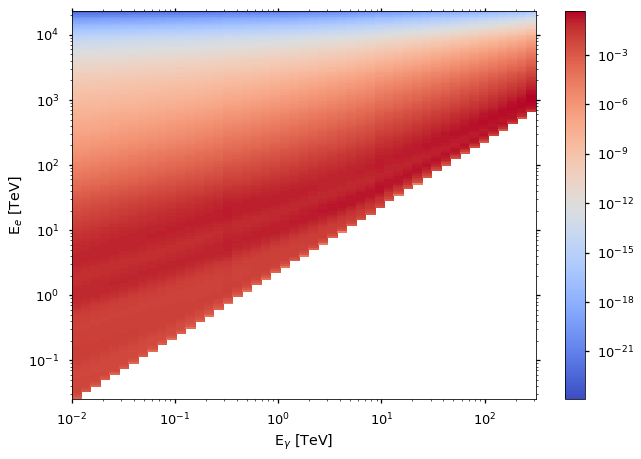

In [40]:
x = np.concatenate(E_g).ravel()
y = np.concatenate(E_e).ravel()#*np.concatenate(E_e_g).ravel()
w = np.concatenate(E_e_g).ravel()
bins_x = np.logspace(np.log10(x.min()),np.log10(x.max()), 50)
bins_y = np.logspace(np.log10(y.min()),np.log10(y.max()), 400)
zi, yi, xi = np.histogram2d(y, x, weights=w, bins=[bins_y,bins_x])
fig, ax = plt.subplots()
im = ax.pcolormesh(xi, yi, zi, cmap='coolwarm', norm=colors.LogNorm())
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('E$_{\gamma}$ [TeV]')
ax.set_ylabel('E$_{e}$ [TeV]')
#ax.set_ylim(1e-1)
fig.colorbar(im);
f.savefig("../plots/electron_gamma_energy_template.png",bbox_inches='tight')
f.savefig("../plots/electron_gamma_energy_template.pdf",bbox_inches='tight')

#### Define some functions and will be used in fitting later

In [41]:
def get_electron_energy_contribution(gamma_bin):
    e_binc = np.power(10,(np.log10(yi[1:])+np.log10(yi[:-1]))/2.)
    g_to_e_bin_dist = zi[:,gamma_bin]
    mask_zeros = g_to_e_bin_dist > 0
    electron_energies = e_binc[mask_zeros]
    contributions = g_to_e_bin_dist[mask_zeros]
    return electron_energies * u.TeV, contributions

In [42]:
def get_sizes(D0, D_index, age, E_e):
    D0 = D0 * u.cm**2 / u.s
    D_eref = 40 * u.TeV
    D = D0 * np.power(E_e / D_eref, D_index).decompose()
    t_cool = np.array(fp.GetCoolingTimeScale(E_e.value,"sum"))[:,1] * u.yr
    r_cool = (np.sqrt(2.0*t_cool*D)).to('pc')
    r_age = (np.sqrt(2.0*age*D)).to('pc')
    r_min = np.minimum(r_cool, r_age)
    r_min_deg = r_min / (pwn_fit.distance * u.pc) * 180 * u.deg / np.pi
    return r_min, r_min_deg, r_cool, r_age, r_min

In [43]:
def get_final_size(D0, D_index, age_fit):
    g_binc = np.power(10,(np.log10(xi[1:])+np.log10(xi[:-1]))/2.)
    final_size = list()
    for gamma_bin,gamma_energy in enumerate(g_binc):
        electron_energies_temp, contributions_temp = get_electron_energy_contribution(gamma_bin)
        r_min, r_min_deg, r_cool, r_age, r_min = get_sizes(D0, D_index, age_fit, electron_energies_temp)
        nume = sp.integrate.simps(r_min_deg*contributions_temp,electron_energies_temp)
        deno = sp.integrate.simps(contributions_temp,electron_energies_temp)
        final_size.append(nume/deno)
    return g_binc * u.TeV, np.array(final_size) * u.deg

In [44]:
def model_for_fitting(ene, D0, D_index):
    #age_fit = pwn_fit.calculate_true_age()*(1-pwn_fit.time_frac_pwn) * u.yr
    age_fit = pwn_fit.calculate_true_age()* u.yr #Jim decided to use the full history of the system
    energy, size = get_final_size(D0, D_index, age_fit)
    spl = splrep(energy.value, size.value)
    return splev(ene, spl)

In [45]:
%%latex
\begin{equation*}
D  = D_0 \left( \frac{E_e}{40 \ \mathrm{TeV}} \right)^{\delta}
\end{equation*}

<IPython.core.display.Latex object>

#### Get the measured extension from HESS

In [46]:
### Extent of component 1 vs energy from HESS analysis ###
min_energy_hess = 0.274 * u.TeV
max_energy_hess = 30 * u.TeV
sigma_hess_comp_1_ebands = np.loadtxt('../../datafiles/3d_modeling_ebands_v2_005_var01_sigma.dat', unpack=True)

In [47]:
sigma_hess_comp_1_ebands

array([[0.42604332, 1.16668538, 3.19487416, 9.62336363],
       [0.6887295 , 0.62288603, 0.61693959, 0.60521965],
       [0.10139267, 0.04756127, 0.05802321, 0.11027797]])

#### Let's do the fit finally!

In [48]:
p1 = [1e28, 0.9]
x = sigma_hess_comp_1_ebands[0]
y = sigma_hess_comp_1_ebands[1]
yerr = sigma_hess_comp_1_ebands[2]
res, cov = opt.curve_fit(model_for_fitting, x, y, p0=p1, sigma=yerr)
err = np.sqrt(np.diag(cov))
print('D0:',res[0],'+/-',err[0])  
print('Delta:',res[1],'+/-',err[1])

D0: 1.1230028197769502e+28 +/- 5.195486679547516e+26
Delta: 0.5759426665967996 +/- 0.12886137889520585


#### for fixed diffusion index

In [49]:
# p1 = [1e28]
# res_0pt33 = opt.curve_fit(lambda x, a: model_for_fitting(x, a, 0.33), x, y, p0=p1, sigma=yerr) 
# res_1pt0 = opt.curve_fit(lambda x, a: model_for_fitting(x, a, 1.0), x, y, p0=p1, sigma=yerr)

#### Plotting the results

In [50]:
#age_fit = pwn_fit.calculate_true_age()*(1-pwn_fit.time_frac_pwn) * u.yr
age_fit = pwn_fit.calculate_true_age()* u.yr #Jim decided to use the full history of the system
energy_toy_model, size_toy_model = get_final_size(7e27, 0.33, 16e3*u.yr) #Lars' Toy model values
energy, size = get_final_size(res[0], res[1], age_fit)
energy1, size1 = get_final_size(res[0], 0.33, age_fit)
energy2, size2 = get_final_size(res[0], 1.0, age_fit)

In [51]:
size_vs_energies = np.array([[energy, size], [energy1, size1], [energy2, size2]])
with open('../data_points/sizes_vs_energies.npy', 'wb') as f:
        np.save(f, size_vs_energies)

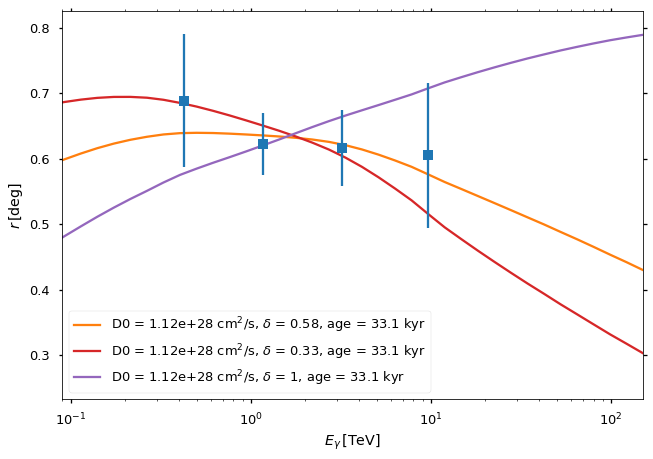

In [52]:
f, ax = plt.subplots()
ax.set_xscale('log')
ax.set_xlabel(r'$E_\gamma\,[\mathrm{TeV}]$')
ax.set_ylabel(r'$r\,[\mathrm{deg}]$')

ax.errorbar(sigma_hess_comp_1_ebands[0], sigma_hess_comp_1_ebands[1], yerr=sigma_hess_comp_1_ebands[2],
                             color='tab:blue', marker='s', linestyle='None', zorder=5)
ax.plot(size_vs_energies[0][0], size_vs_energies[0][1], linestyle='-', color='tab:orange', label=f'D0 = {res[0]:.2e} cm$^{2}$/s, $\delta$ = {res[1]:.2f}, age = {age_fit.value/1e3:.1f} kyr')
ax.plot(size_vs_energies[1][0], size_vs_energies[1][1], linestyle='-', color='tab:red', label=f'D0 = {res[0]:.2e} cm$^{2}$/s, $\delta$ = {0.33}, age = {age_fit.value/1e3:.1f} kyr')
ax.plot(size_vs_energies[2][0], size_vs_energies[2][1], linestyle='-', color='tab:purple', label=f'D0 = {res[0]:.2e} cm$^{2}$/s, $\delta$ = {1}, age = {age_fit.value/1e3:.1f} kyr')
#ax.plot(energy_toy_model.value, size_toy_model.value, linestyle='-', color='tab:green', label=f'D0 = {7e27} cm$^{2}$/s, $\delta$ = {0.33}, age = {16:.1f} kyr (Toy Model)')
ax.legend()
ax.set_xlim(0.09, 150)
f.savefig("../plots/size_vs_gamma_energy.png",bbox_inches='tight',)
f.savefig("../plots/size_vs_gamma_energy.pdf",bbox_inches='tight')

In [53]:
e_binc = np.power(10,(np.log10(yi[1:])+np.log10(yi[:-1]))/2.)*u.TeV
r_min, r_min_deg, r_cool, r_age, r_min = get_sizes(res[0], res[1], age_fit, e_binc)
r_min_0pt33, r_min_deg_0pt33, r_cool_0pt33, r_age_0pt33, r_min_0pt33 = get_sizes(res[0], 0.33, age_fit, e_binc)
r_min_1pt0, r_min_deg_1pt0, r_cool_1pt0, r_age_1pt0, r_min_1pt0 = get_sizes(res[0], 1.0, age_fit, e_binc)
r_min_toyModel, r_min_deg_toyModel, r_cool_toyModel, r_age_toyModel, r_min_toyModel = get_sizes(7e27, 0.33, 16e3*u.yr, e_binc) #what Lars was using

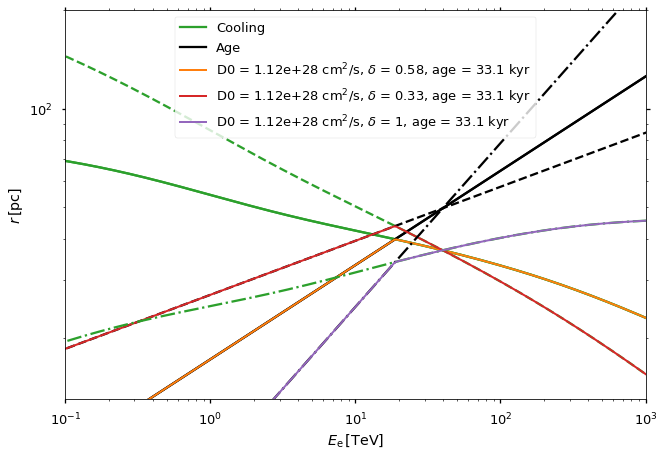

In [54]:
# Panel 2: radius in pc vs electron energy
f, ax = plt.subplots()
ax.loglog()
ax.set_xlabel(r'$E_\mathrm{e}\,[\mathrm{TeV}]$')
ax.set_ylabel(r'$r\,[\mathrm{pc}]$')

ax.plot(e_binc.to_value('TeV'), r_cool.to_value('pc'), color='tab:green', ls='-', label='Cooling')
ax.plot(e_binc.to_value('TeV'), r_age.to_value('pc'), color='black', ls='-', label='Age')
#ax.plot(e_binc.to_value('TeV'), r_min.to_value('pc'), color='tab:orange', lw=2, ls='-', label='Combined')

ax.plot(e_binc.to_value('TeV'), r_cool.to_value('pc'), color='tab:green', ls='-')
ax.plot(e_binc.to_value('TeV'), r_age.to_value('pc'), color='black', ls='-')
ax.plot(e_binc.to_value('TeV'), r_min.to_value('pc'), color='tab:orange', lw=2, ls='-', 
        label=f'D0 = {res[0]:.2e} cm$^{2}$/s, $\delta$ = {res[1]:.2f}, age = {age_fit.value/1e3:.1f} kyr')

ax.plot(e_binc.to_value('TeV'), r_cool_0pt33.to_value('pc'),color='tab:green', ls='--')
ax.plot(e_binc.to_value('TeV'), r_age_0pt33.to_value('pc'),color='black', ls='--')
ax.plot(e_binc.to_value('TeV'), r_min_0pt33.to_value('pc'),color='tab:red', ls='-',  lw=2, 
        label=f'D0 = {res[0]:.2e} cm$^{2}$/s, $\delta$ = {0.33}, age = {age_fit.value/1e3:.1f} kyr')

ax.plot(e_binc.to_value('TeV'), r_cool_1pt0.to_value('pc'), color='tab:green', ls='-.')
ax.plot(e_binc.to_value('TeV'), r_age_1pt0.to_value('pc'), color='black', ls='-.')
ax.plot(e_binc.to_value('TeV'), r_min_1pt0.to_value('pc'), color='tab:purple', ls='-', lw=2, 
        label=f'D0 = {res[0]:.2e} cm$^{2}$/s, $\delta$ = {1}, age = {age_fit.value/1e3:.1f} kyr')


ax.legend()
ax.set_ylim(13, 200)
ax.set_xlim(0.1,1e3)
f.savefig("../plots/size_vs_electron_energy.png",bbox_inches='tight',)
f.savefig("../plots/size_vs_electron_energy.pdf",bbox_inches='tight')

#### Energy density estimates

In [55]:
#convert energy denisty ev/cm3 to temprature in Kelvin                                                                                                                                                            
energy_density_in_photon_field = int_rad_field_density_pwn - 0.25  #eV/cm3 (CMB = 0.25 eV/cm3)                                                                                                                                                                      
temprature = np.power(energy_density_in_photon_field/0.0047225517614,0.25) #Kelvin      
print(temprature, "K")

4.6458018979158116 K


In [56]:
known_properties = {
    #pulsar properties
    'e_dot' : 1.8e36, #erg/sec
    'char_age' : 5.14e4, # yrs                                                                                                                                  
    'P' :  82.755269706e-3,  #sec                                                                                                                              
    'P_dot' :  2.553016e-14 #/sec/sec  
}

In [57]:
def calculate_energy_density(e_dot, char_age, distance, ang_size):
    #conversions
    yr_to_sec = 3.154e7
    pc_to_cm = 3.086e18
    erg_to_eV = 6.242e11
    proj_size = np.deg2rad(ang_size) * distance 
    
    total_E = e_dot * char_age * yr_to_sec
    volume = 4/3 * np.pi * np.power(proj_size * pc_to_cm,3)
    edens = total_E/volume * erg_to_eV
    return edens

In [58]:
ang_size_comp1 = 0.622 #deg #semi-major axis
ang_size_comp2 = 0.0953 #deg
distance = 3.27e3 #pc
e_dot = known_properties['e_dot']
char_age = known_properties['char_age']
edens_comp1 = calculate_energy_density(e_dot, char_age, distance, ang_size_comp1)
edens_comp2 = calculate_energy_density(e_dot, char_age, distance, ang_size_comp2)
print("{:.2e}".format(edens_comp1), "{:.2e}".format(edens_comp2))

3.31e-01 9.20e+01


In [59]:
edens_comp1 = calculate_energy_density(e_dot, pwn_fit.calculate_true_age(), distance, ang_size_comp1)
edens_comp2 = calculate_energy_density(e_dot, pwn_fit.calculate_true_age(), distance, ang_size_comp2)
print("{:.2e}".format(edens_comp1), "{:.2e}".format(edens_comp2), pwn_fit.calculate_true_age())

2.13e-01 5.92e+01 33093.399438774744
